In [ ]:
#|hide
#|default_exp shell

# shell

> A shell for running notebook code without a notebook server

In [ ]:
#|export
from __future__ import annotations

import os
os.environ['MPLBACKEND'] = 'module://matplotlib_inline.backend_inline'

from fastcore.imports import *
from fastcore.basics import *
from fastcore.script import call_parse

import multiprocessing
try:
    if sys.platform == 'darwin': multiprocessing.set_start_method("fork")
except RuntimeError: pass # if re-running cell

import tokenize
from IPython.core.interactiveshell import InteractiveShell
from IPython.core.displayhook import DisplayHook
from IPython.core.displaypub import DisplayPublisher
from base64 import b64encode
from io import StringIO

from execnb.fastshell import FastInteractiveShell
from execnb.nbio import *
from execnb.nbio import _dict2obj

from collections.abc import Callable

In [ ]:
from fastcore.test import *
from base64 import b64decode
from io import BytesIO
from PIL import Image

In [ ]:
#|export

# IPython requires a DisplayHook and DisplayPublisher
# We override `__call__` and `publish` to save outputs instead of printing them
class _CaptureHook(DisplayHook):
    "Called when displaying a result"

    def quiet(self):
        "Should we silence because of ';'?"
        sio = StringIO(self.shell._code)
        tokens = list(tokenize.generate_tokens(sio.readline))
        for t in reversed(tokens):
            if t.type in (tokenize.ENDMARKER, tokenize.NL, tokenize.NEWLINE, tokenize.COMMENT): continue
            return t.type == tokenize.OP and t.string == ';'

    def __call__(self, result=None):
        if result is None or self.quiet(): return
        self.fill_exec_result(result)
        self.shell._result(result)

class _CapturePub(DisplayPublisher):
    "Called when adding an output"
    def publish(self, data, metadata=None, **kwargs): self.shell._add_out(data, metadata, typ='display_data')

In [ ]:
#|export
# These are the standard notebook formats for exception and stream data (e.g stdout)
def _out_exc(ename, evalue, traceback): return dict(ename=str(ename), evalue=str(evalue), output_type='error', traceback=traceback)
def _out_stream(text, name): return dict(name=name, output_type='stream', text=text.splitlines(True))

In [ ]:
#|export
def _format_mimedata(k, v):
    "Format mime-type keyed data consistently with Jupyter"
    if k.startswith('text/'): return v.splitlines(True)
    if k.startswith('image/') and isinstance(v, bytes):
        v = b64encode(v).decode()
        return v+'\n' if not v.endswith('\n') else v
    return v

## CaptureShell -

In [ ]:
#|export
class CaptureShell(FastInteractiveShell):
    "Execute the IPython/Jupyter source code"
    def __init__(self,
                 path:str|Path=None): # Add `path` to python path
        super().__init__(displayhook_class=_CaptureHook, display_pub_class=_CapturePub)
        InteractiveShell._instance = self
        self.out,self.count = [],1
        self.exc = self.result = self._fname = self._cell_idx = self._stdout = self._stderr = None
        if IN_NOTEBOOK:
            try: self.enable_matplotlib('inline')
            except ModuleNotFoundError: pass
        if path: self.set_path(path)

    def enable_matplotlib(self, gui=None):
        "Enable `matplotlib` in a nested shell"
        from matplotlib_inline.backend_inline import configure_inline_support
        configure_inline_support.current_backend = 'unset'
        return super().enable_matplotlib(gui)
    
    def set_path(self, path):
        "Add `path` to python path, or `path.parent` if it's a file"
        path = Path(path)
        if path.is_file(): path = path.parent
        self.run_cell(f"import sys; sys.path.insert(0, '{path.as_posix()}')")

    def enable_gui(self, gui=None):
        "Disable GUI (over-ridden; called by IPython)"
        pass
    
    def _showtraceback(self, etype, evalue, stb: str):
        self.out.append(_out_exc(etype, evalue, stb))
        self.exc = (etype, evalue, '\n'.join(stb))

    def _add_out(self, data, meta, typ='execute_result', **kwargs):
        self._stream()
        fd = {k:_format_mimedata(k,v) for k,v in data.items()}
        self.out.append(dict(data=fd, metadata=meta, output_type=typ, **kwargs))

    def _add_exec(self, result, meta, typ='execute_result'):
        self._add_out(result, meta, execution_count=self.count)
        self.count += 1

    def _result(self, result):
        self.result = result
        self._add_exec(*self.display_formatter.format(result))

    def _stream(self):
        for nm in ('stdout','stderr'):
            attr = '_'+nm
            std = getattr(self, attr)
            if std is not None:
                text = std.getvalue()
                if text:
                    self.out.append(_out_stream(text, nm))
                    setattr(self, attr, StringIO())

In [ ]:
s = CaptureShell()

### Cells -

In [ ]:
#|export
@patch
def run(self:CaptureShell,
        code:str, # Python/IPython code to run
        stdout=True, # Capture stdout and save as output?
        stderr=True): # Capture stderr and save as output?
    "Run `code`, returning a list of all outputs in Jupyter notebook format"
    self._code = code
    self.exc = False
    self.out.clear()
    sys_stdout,sys_stderr = sys.stdout,sys.stderr
    if stdout: self._stdout = sys.stdout = StringIO()
    if stderr: self._stderr = sys.stderr = StringIO()
    try: self.run_cell(code)
    finally: sys.stdout,sys.stderr = sys_stdout,sys_stderr
    self._stream()
    return [*self.out]

In [ ]:
s.run("print(1)")

[{'name': 'stdout', 'output_type': 'stream', 'text': ['1\n']}]

Code can include magics and `!` shell commands:

In [ ]:
s.run("%time 1+1")

[{'name': 'stdout',
  'output_type': 'stream',
  'text': ['CPU times: user 1e+03 ns, sys: 1 us, total: 2 us\n',
   'Wall time: 3.1 us\n']},
 {'data': {'text/plain': ['2']},
  'metadata': {},
  'output_type': 'execute_result',
  'execution_count': 1}]

The result of the last successful execution is stored in `result`:

In [ ]:
s.result

2

A trailing `;` stops the result from being captured:

In [ ]:
s.run("1+2;")

[]

Images and matplotlib figures are captured and base64 encoded:

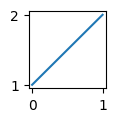

In [ ]:
res = s.run('''import matplotlib.pyplot as plt
plt.figure(figsize=(1,1))
plt.plot([1,2])''')

Image.open(BytesIO(b64decode(res[1]['data']['image/png'])))

If an exception is raised then the exception type, object, and stacktrace are stored in `exc`:

In [ ]:
err_res = s.run('raise Exception("Oops")')
typ,obj,st = s.exc
typ,obj

(Exception, Exception('Oops'))

In [ ]:
print(st)

---------------------------------------------------------------------------
Exception                                 Traceback (most recent call last)
Cell In[1], line 1
----> 1 raise Exception("Oops")

Exception: Oops


In [ ]:
#|export
@patch
def cell(self:CaptureShell, cell, stdout=True, stderr=True):
    "Run `cell`, skipping if not code, and store outputs back in cell"
    if cell.cell_type!='code': return
    self._cell_idx = cell.idx_ + 1
    outs = self.run(cell.source)
    if outs:
        cell.outputs = _dict2obj(outs)
        for o in outs:
            if 'execution_count' in o: cell['execution_count'] = o['execution_count']

In [ ]:
clean = Path('../tests/clean.ipynb')
nb = read_nb(clean)
c = nb.cells[1]
c

```json
{ 'cell_type': 'code',
  'execution_count': None,
  'id': 'b123d6d0',
  'idx_': 1,
  'metadata': {},
  'outputs': [],
  'source': 'print(1)\n2'}
```

In [ ]:
s.cell(c)
c.outputs

[{'name': 'stdout', 'output_type': 'stream', 'text': ['1\n']},
 {'data': {'text/plain': ['2']},
  'metadata': {},
  'output_type': 'execute_result',
  'execution_count': 4}]

In [ ]:
#| export
def find_output(outp, # Output from `run`
                ot='execute_result' # Output_type to find
               ):
    "Find first output of type `ot` in `CaptureShell.run` output"
    return first(o for o in outp if o['output_type']==ot)

In [ ]:
find_output(c.outputs)['data']

```json
{'text/plain': ['2']}
```

In [ ]:
find_output(c.outputs, 'stream')['text']

['1\n']

In [ ]:
#| export
def out_exec(outp):
    "Get data from execution result in `outp`."
    out = find_output(outp)
    if out: return '\n'.join(first(out['data'].values()))

In [ ]:
out_exec(c.outputs)

'2'

In [ ]:
#| export
def out_stream(outp):
    "Get text from stream in `outp`."
    out = find_output(outp, 'stream')
    if out: return ('\n'.join(out['text'])).strip()

In [ ]:
out_stream(c.outputs)

'1'

In [ ]:
#| export
def out_error(outp):
    "Get traceback from error in `outp`."
    out = find_output(outp, 'error')
    if out: return '\n'.join(out['traceback'])

In [ ]:
print(out_error(err_res))

---------------------------------------------------------------------------
Exception                                 Traceback (most recent call last)
Cell In[1], line 1
----> 1 raise Exception("Oops")

Exception: Oops


### NBs -

In [ ]:
#|export
def _false(o): return False

@patch
def run_all(self:CaptureShell,
            nb, # A notebook read with `nbclient` or `read_nb`
            exc_stop:bool=False, # Stop on exceptions?
            preproc:Callable=_false, # Called before each cell is executed
            postproc:Callable=_false, # Called after each cell is executed
            inject_code:str|None=None, # Code to inject into a cell
            inject_idx:int=0 # Cell to replace with `inject_code`
           ):
    "Run all cells in `nb`, stopping at first exception if `exc_stop`"
    if inject_code is not None: nb.cells[inject_idx].source = inject_code
    for cell in nb.cells:
        if not preproc(cell):
            self.cell(cell)
            postproc(cell)
        if self.exc and exc_stop: raise self.exc[1] from None

In [ ]:
nb.cells[2].outputs

[]

In [ ]:
s.run_all(nb)
nb.cells[2].outputs

[{'data': {'text/plain': ['<IPython.core.display.Markdown object>'],
   'text/markdown': ["This is *bold*. Here's a [link](https://www.fast.ai)."]},
  'metadata': {},
  'output_type': 'execute_result',
  'execution_count': 6}]

With `exc_stop=False` (the default), execution continues after exceptions, and exception details are stored into the appropriate cell's output:

In [ ]:
nb.cells[-1].source

'raise Exception("Oopsie!")'

In [ ]:
nb.cells[-1].outputs

[{'ename': "<class 'Exception'>",
  'evalue': 'Oopsie!',
  'output_type': 'error',
  'traceback': ['\x1b---------------------------------------------------------------------------\x1b',
   '\x1bException\x1b                                 Traceback (most recent call last)',
   'Input \x1bIn [1]\x1b, in \x1b<cell line: 1>\x1b()\x1b\n\x1b----> 1\x1b \x1braise\x1b \x1bException\x1b(\x1b"\x1b\x1bOopsie!\x1b\x1b"\x1b)\n',
   '\x1bException\x1b: Oopsie!']}]

With `exc_stop=True` (the default), exceptions in a cell are raised and no further processing occurs:

In [ ]:
try: s.run_all(nb, exc_stop=True)
except Exception as e: print(f"got exception: {e}")

got exception: Oopsie!


We can pass a function to `preproc` to have it run on every cell. It can modify the cell as needed. If the function returns `True`, then that cell will not be executed. For instance, to skip the cell which raises an exception:

In [ ]:
nb = read_nb(clean)
s.run_all(nb, preproc=lambda c: 'raise' in c.source)

This cell will contain no output, since it was skipped.

In [ ]:
nb.cells[-1].outputs

[]

In [ ]:
nb.cells[1].outputs

[{'name': 'stdout', 'output_type': 'stream', 'text': ['1\n']},
 {'data': {'text/plain': ['2']},
  'metadata': {},
  'output_type': 'execute_result',
  'execution_count': 11}]

You can also pass a function to `postproc` to modify a cell after it is executed.

In [ ]:
#|export
@patch
def execute(self:CaptureShell,
            src:str|Path, # Notebook path to read from
            dest:str|None=None, # Notebook path to write to
            exc_stop:bool=False, # Stop on exceptions?
            preproc:Callable=_false, # Called before each cell is executed
            postproc:Callable=_false, # Called after each cell is executed
            inject_code:str|None=None, # Code to inject into a cell
            inject_path:str|Path|None=None, # Path to file containing code to inject into a cell
            inject_idx:int=0 # Cell to replace with `inject_code`
):
    "Execute notebook from `src` and save with outputs to `dest"
    nb = read_nb(src)
    self._fname = src
    self.set_path(Path(src).parent.resolve())
    if inject_path is not None: inject_code = Path(inject_path).read_text()
    self.run_all(nb, exc_stop=exc_stop, preproc=preproc, postproc=postproc,
                 inject_code=inject_code, inject_idx=inject_idx)
    if dest: write_nb(nb, dest)

This is a shortcut for the combination of `read_nb`, `CaptureShell.run_all`, and `write_nb`.

In [ ]:
s = CaptureShell()
try:
    s.execute(clean, 'tmp.ipynb')
    print(read_nb('tmp.ipynb').cells[1].outputs)
finally: Path('tmp.ipynb').unlink()

[{'name': 'stdout', 'output_type': 'stream', 'text': ['1\n']}, {'data': {'text/plain': ['2']}, 'execution_count': 2, 'metadata': {}, 'output_type': 'execute_result'}]


In [ ]:
p = Path.home()/'git'/'fastcore'/'nbs'
n = p/'03a_parallel.ipynb'

In [ ]:
#|export
@patch
def prettytb(self:CaptureShell, 
             fname:str|Path=None): # filename to print alongside the traceback
    "Show a pretty traceback for notebooks, optionally printing `fname`."
    fname = fname if fname else self._fname
    _fence = '='*75
    cell_intro_str = f"While Executing Cell #{self._cell_idx}:" if self._cell_idx else "While Executing:"
    cell_str = f"\n{cell_intro_str}\n{self.exc[-1]}"
    fname_str = f' in {fname}' if fname else ''
    return f"{type(self.exc[1]).__name__}{fname_str}:\n{_fence}\n{cell_str}\n"

If an error occurs while running a notebook, you can retrieve a pretty version of the error with the `prettytb` method: 

In [ ]:
s = CaptureShell()
try:
    s.execute('../tests/error.ipynb', exc_stop=True)
except:
    print(s.prettytb())

AssertionError in ../tests/error.ipynb:

While Executing Cell #2:
---------------------------------------------------------------------------
AssertionError                            Traceback (most recent call last)
Input In [1], in <cell line: 3>()
      1 # some comments
      2 print('hello')
----> 3 foo()

File ~/git/execnb/tests/err.py:2, in foo()
      1 def foo():
----> 2     assert 13 == 98

AssertionError: 



### Tests -

In [ ]:
#|hide
# Trailing `;` stops data from being captured
res = CaptureShell().run('1+1;')
test_eq(res, [])

# Newlines, whitespace, and comments after `;` are ignored
res = CaptureShell().run('1+1;\n  #commented_func()')
test_eq(res, [])

In [ ]:
#|hide
# Streams are split on and keep newlines
res = CaptureShell().run(r"print('a\nb'); print('c\n\n'); print('d')")
test_eq(res[0]['text'], ['a\n', 'b\n', 'c\n', '\n', '\n', 'd\n'])

In [ ]:
#|hide
# Text mime data are split on and keep newlines
res = CaptureShell().run(r"from IPython.display import Markdown; display(Markdown('a\nb'))")
test_eq(res[0]['data']['text/markdown'], ['a\n', 'b'])

In [ ]:
#|hide
# Binary image mime data are base64-encoded and end in a single `\n`

def _pil2b64(im): return b64encode(im._repr_png_()).decode()+'\n'
im = Image.new('RGB', (3,3), 'red')
imb64 = _pil2b64(im)

res = CaptureShell().run("from PIL import Image; Image.new('RGB', (3,3), 'red')")
test_eq(res[0]['data']['image/png'], imb64)

In [ ]:
#|hide
# `display_data` flushes stdout and stderr - in that order
res = CaptureShell().run("import sys; sys.stderr.write('Error!'); print(1); display(1)")
test_eq(res, [{'name': 'stdout', 'output_type': 'stream', 'text': ['1\n']},
              {'name': 'stderr', 'output_type': 'stream', 'text': ['Error!']},
              {'data': {'text/plain': ['1']}, 'metadata': {}, 'output_type': 'display_data'}])

In [ ]:
#|hide
# Consecutive writes to stdout are grouped
res = CaptureShell().run('print(1); print(2); print(3)')
test_eq(res, [{'name': 'stdout', 'output_type': 'stream', 'text': ['1\n', '2\n', '3\n']}])

In [ ]:
#|hide
# Consecutive writes to stdout are grouped despite an intermediate write to stderr, which is captured after
res = CaptureShell().run("import sys; print(1); print(2); sys.stderr.write('Error!'); print(3)")
test_eq(res, [{'name': 'stdout', 'output_type': 'stream', 'text': ['1\n', '2\n', '3\n']},
              {'name': 'stderr', 'output_type': 'stream', 'text': ['Error!']}])

In [ ]:
#|hide
# `execute_result` is always last
res = CaptureShell().run("import sys; sys.stderr.write('Error!'); print(1); display(1); 1")
test_eq(res, [{'name': 'stdout', 'output_type': 'stream', 'text': ['1\n']},
              {'name': 'stderr', 'output_type': 'stream', 'text': ['Error!']},
              {'data': {'text/plain': ['1']}, 'metadata': {}, 'output_type': 'display_data'},
              {'data': {'text/plain': ['1']}, 'metadata': {}, 'output_type': 'execute_result', 'execution_count': 1}])

## Params -

If you pass `inject_code` to `CaptureShell.execute` or `CaptureShell.run_all`, the source of `nb.cells[inject_idx]` will be replaced with `inject_code`. By default, the first cell is replaced. For instance consider this notebook:

In [ ]:
nb = read_nb('../tests/params.ipynb')
for c in nb.cells: print('- ',c.source)

-  a=1
-  print(a)


We can replace the first cell with `a=2` by passing that as `inject_code`, and the notebook will run with that change:

In [ ]:
nb = read_nb('../tests/params.ipynb')
s.run_all(nb, inject_code="a=2")
list(nb.cells)

[{'cell_type': 'code',
  'execution_count': 1,
  'id': 'a63ce885',
  'metadata': {},
  'outputs': [],
  'source': 'a=2',
  'idx_': 0},
 {'cell_type': 'code',
  'execution_count': 2,
  'id': 'ea528db5',
  'metadata': {},
  'outputs': [{'name': 'stdout', 'output_type': 'stream', 'text': ['2\n']}],
  'source': 'print(a)',
  'idx_': 1}]

This can be used with `CaptureShell.execute` to parameterise runs of models in notebooks. Place any defaults for configuration code needed in the first cell, and then when running `execute` pass in new parameters as needed in `inject_code`. To replace only some of the defaults, leave an empty cell as the second cell, and inject code using `inject_idx=1` to replace the empty second cell with code that overrides some of the defaults set in the first cell. When using `execute` you can pass `inject_path` instead of `inject_code` to read the injected code from a file.

## cli -

In [ ]:
#|export
@call_parse
def exec_nb(
    src:str, # Notebook path to read from
    dest:str='', # Notebook path to write to
    exc_stop:bool=False, # Stop on exceptions?
    inject_code:str=None, # Code to inject into a cell
    inject_path:str=None, # Path to file containing code to inject into a cell
    inject_idx:int=0 # Cell to replace with `inject_code`
):
    "Execute notebook from `src` and save with outputs to `dest`"
    CaptureShell().execute(src, dest, exc_stop=exc_stop, inject_code=inject_code,
                           inject_path=inject_path, inject_idx=inject_idx)

This is the command-line version of `CaptureShell.execute`. Run `exec_nb -h` from the command line to see how to pass arguments. If you don't pass `dest` then the output notebook won't be saved; this is mainly useful for running tests.

## export -

In [ ]:
#|hide
import nbdev; nbdev.nbdev_export()